In [1]:
!apt-get install -y libgl1-mesa-dev libgl1-mesa-glx libglew-dev libosmesa6-dev software-properties-common
!apt-get install -y patchelf
!pip install gym
!pip install free-mujoco-py==2.1.4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties-common is already the newest version (0.96.24.32.18).
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  libgl1-mesa-glx libglew-dev libglew2.0 libosmesa6 libosmesa6-dev
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,916 kB of archives.
After this operation, 12.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew2.0 amd64 2.0.0-5 [140 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew-dev amd64 2.0.0-5 [120 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libosmesa6 amd64 20.0.8-

In [2]:
import mujoco_py
import gym
import time
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
import string
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizer
from torch.distributions import Normal
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from torch.optim import Adam
import numpy as np

running build_ext
building 'mujoco_py.cymj' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/mujoco_py -I/usr/local/lib/python3.7/dist-packages/mujoco_py/binaries/linux/mujoco210/include -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I/usr/include/python3.7m -c /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.c -o /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.o -fopenmp -w
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wal

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
class ReplayBuffer(object):

    def __init__(self, state_dimension, action_dimension, max_size=int(1e6)):
        self.max_size = max_size
        self.counter = 0
        self.size = 0
        self.storage = [np.zeros((max_size, state_dimension)), np.zeros((max_size, action_dimension)), np.zeros((max_size, 1)), np.zeros((max_size, state_dimension)), np.zeros((max_size, 1))]

    def add(self, state, action, reward, next_state, done):
        self.storage[0][self.counter] = state
        self.storage[1][self.counter] = action
        self.storage[2][self.counter] = reward
        self.storage[3][self.counter] = next_state
        self.storage[4][self.counter] = 1.0 - done
        self.counter = (self.counter + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.FloatTensor(self.storage[0][ind]).to(device),
            torch.FloatTensor(self.storage[1][ind]).to(device),
            torch.FloatTensor(self.storage[2][ind]).to(device),
            torch.FloatTensor(self.storage[3][ind]).to(device),
            torch.FloatTensor(self.storage[4][ind]).to(device)
        )

In [61]:
class Actor(torch.nn.Module):
    def __init__(self, state_dim, n_actions, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action
        self.layer = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.LeakyReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, n_actions),
            nn.Tanh()
        )
    def forward(self, state):
        return self.layer(state)


class Critic(torch.nn.Module):
    def __init__(self, state_dim, n_actions):
        super(Critic, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(state_dim+n_actions, 128),
            nn.LeakyReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(state_dim+n_actions, 128),
            nn.LeakyReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 1)
        )

    def forward(self, state, action):
        out = torch.cat([state, action], 1)
        return self.layer1(out), self.layer2(out)

In [62]:
class DDPG(object):
    def __init__(self, state_dim, n_actions, max_action, gamma=0.99, tau=0.005, noise=0.2, noise_max=0.5, update_period=4, lr=5e-4):
        self.actor = Actor(state_dim, n_actions, max_action).to(device)
        self.actor_target = deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic = Critic(state_dim, n_actions).to(device)
        self.critic_target = deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)
        self.max_action = max_action
        self.gamma = gamma
        self.tau = tau
        self.noise = noise
        self.noise_max = noise_max
        self.update_period = update_period
        self.iter = 0

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    @staticmethod
    def soft_update(local_model, target_model, tau):
        for param, target_param in zip(local_model.parameters(), target_model.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def train(self, memory, batch_size=100):
        self.iter += 1
        state, action, reward, next_state, not_done = memory.sample(batch_size)
        with torch.no_grad():
            curr_noise = (torch.randn_like(action) * self.noise).clamp(-self.noise_max, self.noise_max)
            next_action = (self.actor_target(next_state) + curr_noise).clamp(-self.max_action, self.max_action)
            target_q1, target_q2 = self.critic_target(next_state, next_action)
            target_q = torch.min(target_q1, target_q2)
            target_q = reward + not_done * self.gamma * target_q

        current_q1, current_q2 = self.critic(state, action)
        critic_loss = func.mse_loss(current_q1, target_q) + func.mse_loss(current_q2, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        if self.iter % self.update_period == 0:
            q1, q2 = self.critic(state, self.actor(state))
            actor_loss = -(q1 + q2).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            DDPG.soft_update(self.critic, self.critic_target, self.tau)
            DDPG.soft_update(self.actor, self.actor_target, self.tau)

In [64]:
import gym

def evaluate(agent, eval_env, episodes=10):
    reward = 0
    t_max = 100000
    for i in range(episodes):
        state = eval_env.reset()
        is_done = False
        for _ in range(t_max):
            action = agent.select_action(np.array(state))
            state, curr_reward, is_done, _ = eval_env.step(action)
            reward += curr_reward
            if is_done:
                break
    return reward / episodes

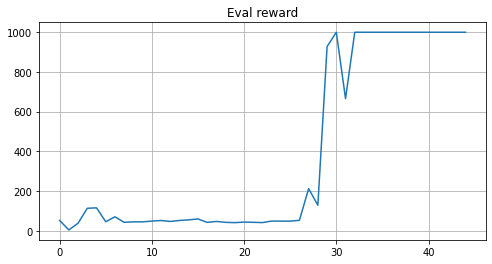

In [65]:
from IPython.display import clear_output

env_name = 'InvertedPendulum-v2'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
scale = float(env.action_space.high[0])

batch_size = 256
agent = DDPG(state_dim=state_dim, n_actions=n_actions, max_action=scale, gamma=0.99, tau=0.005)
evaluations = []
memory = ReplayBuffer(state_dim, n_actions)
state = env.reset()
is_done = False
episode_reward = 0
episode_step = 0
episode_num = 0
evaluations = []
episode_rewards = []
noise = 0.1
time_start = 5000

for t in range(1, 50000):
    episode_step += 1
    if t >= time_start:
        action = (agent.select_action(np.array(state)) + scale * noise * np.random.randn(n_actions)).clip(-scale, scale)
    else:
        action = env.action_space.sample()
    next_state, reward, is_done, _ = env.step(action)
    if episode_step < env._max_episode_steps:
        mask = is_done
    else:
        mask = 0
    memory.add(state, action, reward, next_state, mask)
    state = next_state
    episode_reward += reward
    if t >= time_start:
        agent.train(memory)
    if is_done:
        episode_rewards.append(episode_reward)
        state = env.reset()
        is_done = False
        episode_reward = 0
        episode_step = 0
        episode_num += 1
    if t >= time_start and t % 1000 == 0:
        evaluations.append(evaluate(agent, env))
        #print('evaluation reward:', np.round(np.array(evaluations).mean(), 2))
        fig = plt.figure(figsize=[8, 4])
        plt.title("Eval reward")
        clear_output(True)
        plt.plot(evaluations)
        plt.grid()
        plt.show()

In [67]:
import sys, os
from gym.wrappers import Monitor
eval_env = Monitor(gym.make(env_name), './video', force=True)
evaluate(agent, eval_env, episodes=10)
eval_env.close()
from IPython.display import HTML

video_names = list(filter(lambda s: s.endswith(".mp4"), os.listdir("./video/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./video/"+video_names[-1]))